In [1]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter

In [2]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

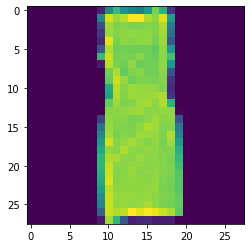

In [95]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[1100])

In [96]:
images.max()

0.00392156862745098

In [6]:
images.shape

(2000, 28, 28)

In [66]:
images.max()

0.00392156862745098

In [58]:
images_normalized = (images/ 255.0)

images_normalized

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.41234518e-07, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.41234518e-07, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

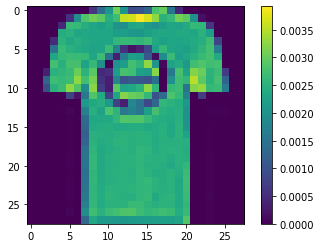

In [62]:
plt.imshow(images[0])
plt.colorbar()

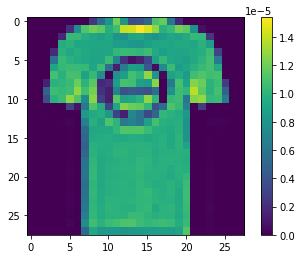

In [60]:
plt.imshow(images_normalized[0])
plt.colorbar()

In [50]:
import pandas as pd

def min_max_normalization(s):

    normalized_s=(s-s.min())/(s.max()-s.min())
    
    return normalized_s

def z_normalization(s):
    
    normalized_s=(s-s.mean())/s.std()
    
    return normalized_s


def variance_map(images, images_normalization, variance_normalization=None):

    variance_series = pd.DataFrame(images.reshape(2000, 28 * 28)).var().rename("variance")
    
    if variance_normalization:
        variance_series = variance_normalization(variance_series)

    variance_map = np.array(variance_series).reshape(28, 28)

    variance_map 
    
    plt.imshow(variance_map)
    plt.colorbar()

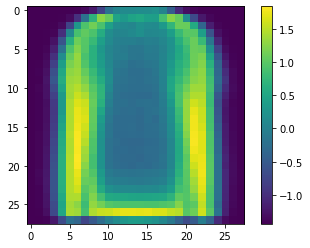

In [51]:
variance_map(images, variance_normalization=z_normalization)

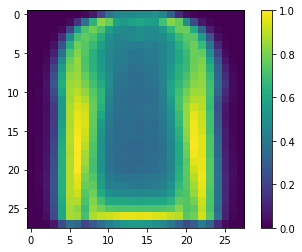

In [52]:
variance_map(images, variance_normalization=min_max_normalization)

In [68]:
28 * 28

784

In [67]:
28 * (24)

672

In [97]:
x_train = images.reshape(2000, 28 * 28)

In [106]:
n_qubits_data = 8

In [107]:
from sklearn.decomposition import PCA

# Create an instance of PCA
pca = PCA(n_components=2 ** n_qubits_data)

# Fit PCA on your 784-dimensional data
pca.fit(x_train)

# Apply dimensionality reduction on your data
data_pca = pca.transform(x_train)

In [108]:
data_pca.shape

(2000, 256)

In [109]:
import cmath
#Funtion to normalize the data of an array
'''
Input = Array with n values
Output = Array with normalized valued
'''
def Normalize(row):
    #We calculate the squareroot of the sum of the square values of the row
    suma = np.sqrt(np.sum(row**2)) 
    if suma == 0.:
        #If the sum is zero we return a 0
        return 0.0
    #Else we divide each value between the sum value above
    row = row/suma
    return row 

#Normalize the training set data
for i in range(len(x_train)):
    data_pca[i] = Normalize(data_pca[i])

    
print("The sum of the states from the training set 0",np.sum(data_pca[0]**2))


The sum of the states from the training set 0 1.0


In [111]:
data_pca.shape

(2000, 256)

In [83]:
num_layers = 1 #Number of layers
#Making a ndarray of floats based on the number of layers
params = np.random.random(10*(num_layers))

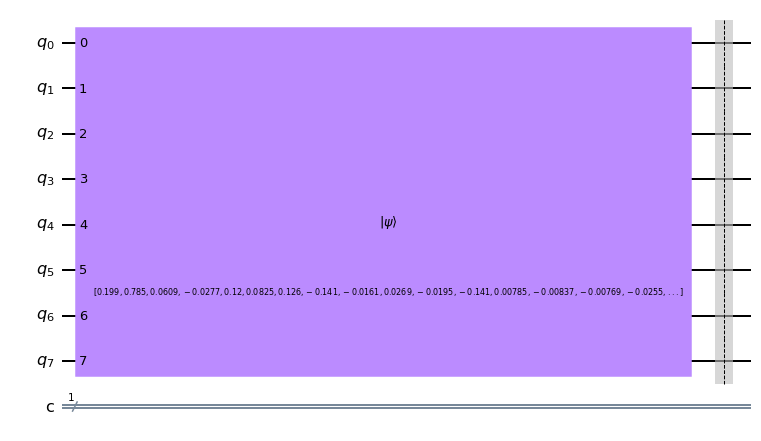

In [123]:
from qiskit import QuantumCircuit
#Function to create a quantum circuit based on the number of qubit and a
#vector of complex amplitudes to initialize to
'''
Input: Number of qubits, vector of complex amplitudes
Output: Quantum Circuit
'''
def input_data(n,inputs):
    circuit = QuantumCircuit(n,1) #create the quantum circuit with n qubits
    #initialization of the circuit with the vector of amplitudes
    inputs
    circuit.initialize(inputs, range(0,n,1)) 
    circuit.barrier() #Draw a barrier
    return circuit

#Example of a quantum circuit with the first row of te trainig set
input_data(n_qubits_data, data_pca[0]).draw(output="mpl")

In [117]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate

#Function to create a quantum variational circuit
'''
Input: number of qubits, number of layers, parameters to initialized the circuit
Output: Quantum Circuit
'''
def vqc(n, num_layers,params):
    #Set the number of layers and qubits
    #ParameterVectors are initialized with a string identifier and an integer specifying the vector length
    parameters = ParameterVector('θ', 10*(num_layers))
    len_p = len(parameters)
    circuit = QuantumCircuit(n, 1) #create the quantum circuit with n qubits
    

    #Creating the circuit for each layer
    for layer in range(num_layers):
        #Applying a ry gate in each qubit
        for i in range(n):
            #the rotation of the ry gate is defined in the parameters list
            #based on the layer
            circuit.ry(parameters[(layer)+i], i)
        circuit.barrier() #Create a barrier

        circuit.cx(2,0) #Apply a CNOT gate between the qubit 2 and 0
        circuit.cx(3,1) #Apply a CNOT gate between the qubit 3 and 1
        circuit.cx(5,4) #Apply a CNOT gate between the qubit 5 and 4
        circuit.barrier() #Create a barrier
        
        #Apply a RY gate in the qubit 0 with the rotation specified in the parameter list
        circuit.ry(parameters[6+(layer)],0)
        #Apply a RY gate in the qubit 1 with the rotation specified in the parameter list
        circuit.ry(parameters[7+(layer)],1)
        #Apply a RY gate in the qubit 4 with the rotation specified in the parameter list
        circuit.ry(parameters[8+(layer)],4)
        circuit.barrier() #Create a barrier
        
        circuit.cx(4,1) #Apply a CNOT gate between the qubit 4 and 1
        circuit.barrier() #Create a barrier
        
        #Apply a RY gate in the qubit 1 with the rotation specified in the parameter list
        circuit.ry(parameters[9+(layer)], 1)
        circuit.barrier() #Create a barrier
        

    #Creating a parameters dictionary
    params_dict = {}
    i = 0
    for p in parameters:
        #The name of the value will be the string identifier and an integer specifying the vector length
        params_dict[p] = params[i] 
        i += 1
    #Assign parameters using the assign_parameters method
    circuit = circuit.assign_parameters(parameters = params_dict)
    return circuit

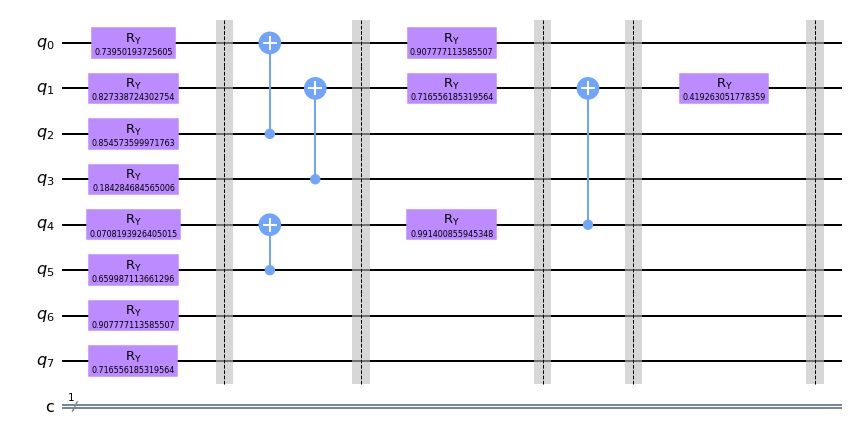

In [118]:
vqc(n_qubits_data, num_layers,params).draw(output="mpl")


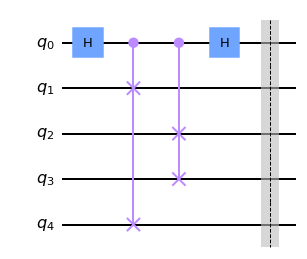

In [119]:
#Fucntion to make a swap test
'''
Input: Number of qubits
Output: Quantum circuit
'''
def swap_test(n):
    qubits_values = 2*n+1 #Create a new qubit value to create our circuit
    qc = QuantumCircuit(qubits_values) #Create the quantum circuit with the qubits value
    qc.h(0) #Applying a H gate to the first qubit
    for i in range(n):
        #Applying a cswap gate between the first quibit and the i+1 and 2*n-i qubits
        qc.cswap(0,i+1,2*n-i) 
    qc.h(0) #Applying a H gate to the first qubit
    qc.barrier() #Create a barrier
    return qc
#Example of a swap test with 2 quibits
swap_test(2).draw(output="mpl")

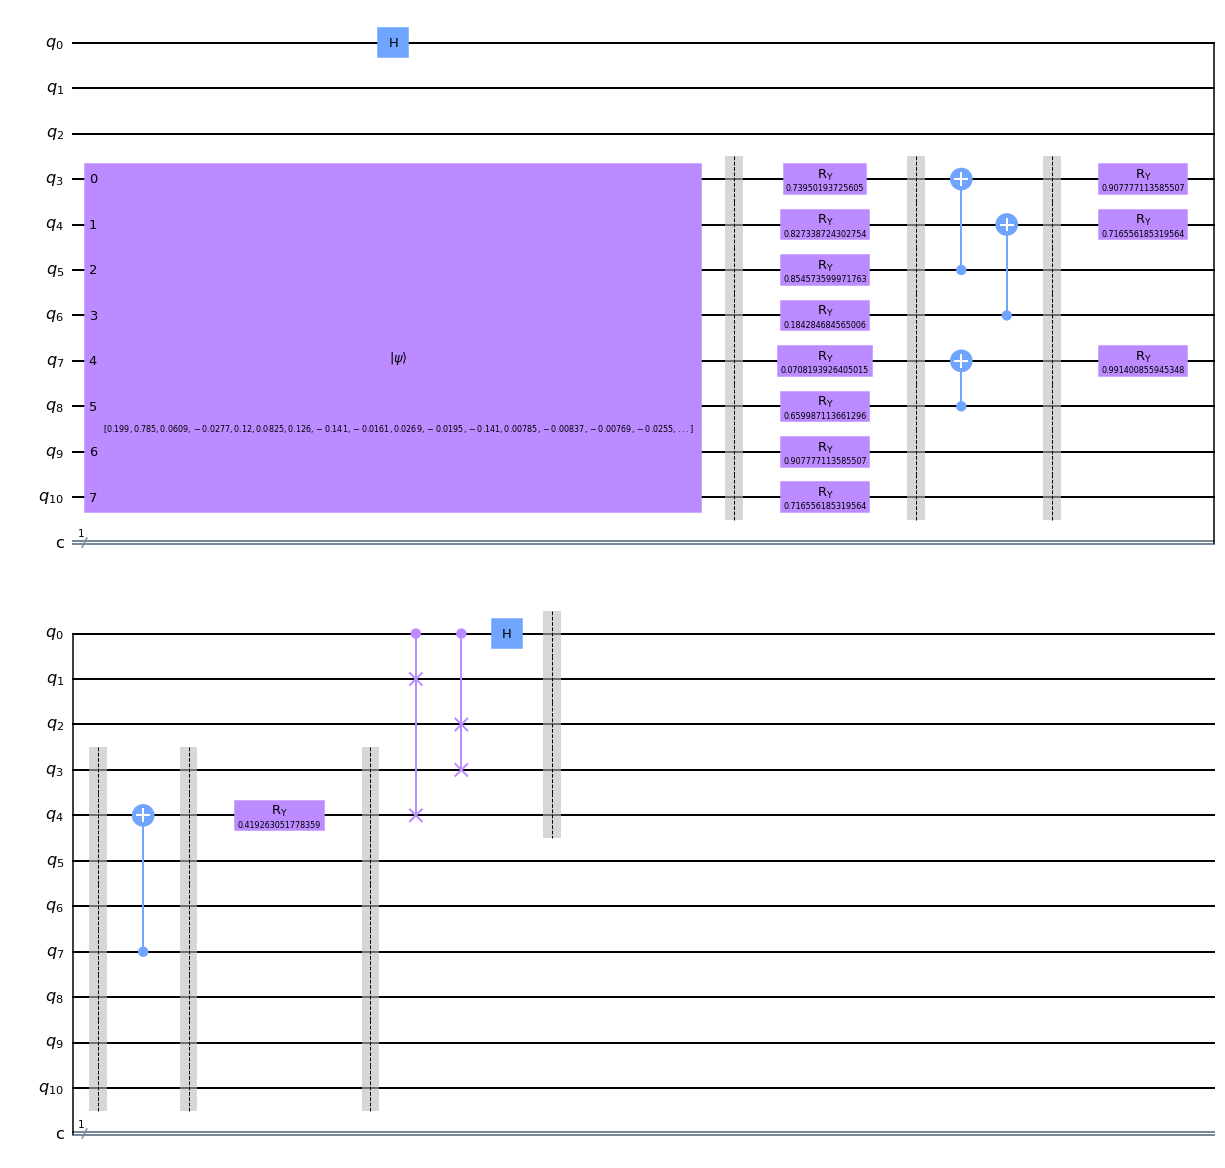

In [126]:
size_reduce = 2 #Number of qubits we want to reduce
circuit_init = input_data(n_qubits_data, data_pca[0]) #Create a inicial circui
circuit_vqc = vqc(n_qubits_data,num_layers,params) #Create a quantum variational circuit
circuit_swap_test = swap_test(size_reduce) #Create a swap test circuit

#Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
circuit_full = QuantumCircuit(n_qubits_data+size_reduce+1,1)

#Combine the initial circuit, the quantum variatinal circuit and the swap test
#For the initial circuit and QVC we start at the qubit size_reduce + 1
#For the swap test we start at the qubit 0
circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n_qubits_data+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n_qubits_data+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
circuit_full.draw(output="mpl")

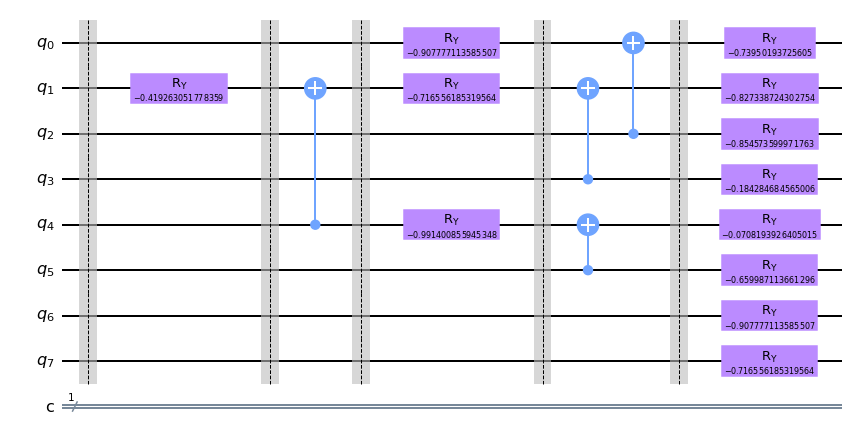

In [127]:
vqc(n_qubits_data,num_layers,params).inverse().draw(output = "mpl")


In [128]:
from random import shuffle
from scipy.optimize import minimize 

In [131]:
n_qubits_data

8

In [138]:
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister

#Function to identify a function cost
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Function cost
'''
def objective_function(params):
    n = n_qubits_data
    costo = 0
    shuffle(data_pca) #reorganize the order of the train set items
    length = 5 #We only will consider the first five elements of the taining set
    #For each item of the trainig set
    for i in range(length):
        circuit_init = input_data(n, data_pca[i])#Create a inicial circuit
        circuit_vqc = vqc(n, num_layers,params) #Create a quantum variational circuit
        circuit_swap_test = swap_test(size_reduce) #Create a swap test circuit

        #Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
        circuit_full = QuantumCircuit(n + size_reduce+1,1)
        
        #Combine the initial circuit, the quantum variatinal circuit and the swap test
        #For the initial circuit and QVC we start at the qubit size_reduce + 1
        #For the swap test we start at the qubit 0
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
        
        #
        circuit_full.measure(0, 0) # Measure the first qubit
        
        #qc.draw()
        
        #Execute the circuit in the qasm_simulator
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=shots )
        counts = job.result().get_counts() #Count the results of the execution
        probs = {} #Calculate the probabilities of 0 and 1 state
        
        for output in ['0','1']:
            if output in counts:
                probs[output] = counts[output]/shots #Calculate the average of a state
            else:
                probs[output] = 0
        costo += (1 + probs['1'] - probs['0']) #Update the actual function cost
    
    print(costo / length)
    
    return costo / length

shots = 1024 #Number of shots
max_iter = 2

for i in range(1):
    #Minimization of the objective_fucntion by a COBYLA method
    options = {
        "max_iter": max_iter
    }
    minimum = minimize(objective_function, params, method='COBYLA', tol=1e-6, options=options)
    params = minimum.x #Get the solution array
    #Show the cost of the solution array
    print(" cost: ",objective_function(params))
    print(params)

/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:702: OptimizeWarning: Unknown solver options: max_iter
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


0.860546875
0.787109375
0.845703125
0.745703125
0.786328125
0.787890625
0.7515625
0.738671875
0.7625
0.7453125
0.84140625
0.41875
0.390234375
0.467578125
0.36484375
0.41875
0.426953125
0.370703125
0.490234375
0.4140625
0.581640625
0.421484375
0.361328125
0.331640625
0.2703125
0.26875
0.27421875
0.294140625
0.32578125
0.253515625
0.245703125
0.2828125
0.24296875
0.260546875
0.260546875
0.31328125
0.269140625
0.264453125
0.25859375
0.230078125
0.269921875
0.2484375
0.265625
0.270703125
0.260546875
0.25390625
0.25859375
0.24765625
0.249609375
0.238671875
0.266015625
0.25390625
0.248046875
0.238671875
0.2359375
0.252734375
0.25625
0.270703125
0.231640625
0.25
0.262109375
0.25859375
0.255078125
0.24609375
0.246484375
0.234765625
0.252734375
0.264453125
0.224609375
0.26796875
0.244921875
0.263671875
0.259765625
0.262109375
0.234375
0.24765625
0.256640625
0.251171875
0.244921875
0.24609375
0.244140625
0.24921875
0.26015625
0.237109375
0.242578125
0.24609375
0.248828125
0.257421875
0.246484375

In [ ]:
params_minimized = params

In [ ]:
# P Q C
# Rotations CRY, CRZ < - controlled by parameters
# -> 

In [145]:
import tqdm

In [147]:
#Function to compress the training set values
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with compress values
'''
def compress_result(*, params, n, size_reduce, X, shots=1024):
    reduce = [] #List to save the compress values
    #For each row in the training set we will
    for i in tqdm.tqdm(range(len(X))):
        circuit_init = input_data(n, X[i]) #Create a inicial circuit
        circuit_vqc = vqc(n,num_layers,params) #Create a quantum variational circuit
        
        #Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
        circuit_full = QuantumCircuit(n, n-size_reduce)

        #Combine the initial circuit, the quantum variatinal circuit
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full) #Known the length of the circuit
        #For each n - the the desired qubits to reduce we will
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i) #Measure the circuit in the position size_reduce+i 
        #We will execute the full circuit in the qasm simulator
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'), shots=shots )
        result = job.result().get_counts() #Get the results of the execution
        #Get the probabilities of each state
        probs = {k: np.sqrt(v / shots) for k, v in result.items()}
        reduce.append(probs) #Save the probabilities
        
    return reduce
        
#Call the compress_result_train function with the parameters defined above
reduce_img = compress_result(params=params_minimized, n=n_qubits_data, size_reduce=size_reduce, X=data_pca, shots=1024)
train_reduce = [] #List to save the new values of the image reduction
#for each value in the reduce_img list
for i in reduce_img:
    index_image = [] #List to save the reduction values
    #We now take in count we want a 6X6 image
    size = n_qubits_data - size_reduce 
    
    for j in range(size * size):
        bin_index = bin(j)[2:] #We take the binary value of j from the 2 position to the end
        
        while len(bin_index) < size: #While bin_index is less than 4
            bin_index = '0'+bin_index #We concatenate a 0 string at the beginnig
        try:  
            #We try to save the element of the row in the position bin_index
            index_image.append(i[bin_index])
        except:
            index_image.append(0) #If we can't, we only save a 0
            
    #We save the new imagen values in the train_recuce list
    train_reduce.append(np.array(index_image))

100%|██████████| 2000/2000 [00:37<00:00, 53.27it/s]


In [143]:
params_minimized

array([ 3.25402569, -0.87167382,  2.74528436,  0.39132926, -1.3705645 ,
        0.34323234,  2.93714471,  0.80357588,  1.32506271,  0.17947663])

In [150]:
reduce_img[0]

{'110111': 0.03125,
 '001001': 0.04419417382415922,
 '101101': 0.04419417382415922,
 '110010': 0.03125,
 '101111': 0.04419417382415922,
 '110000': 0.06987712429686843,
 '101110': 0.03125,
 '001010': 0.04419417382415922,
 '011010': 0.04419417382415922,
 '100100': 0.0625,
 '001110': 0.04419417382415922,
 '100011': 0.04419417382415922,
 '110100': 0.06987712429686843,
 '000010': 0.04419417382415922,
 '010110': 0.09375,
 '000011': 0.04419417382415922,
 '100000': 0.05412658773652741,
 '101100': 0.04419417382415922,
 '101010': 0.04419417382415922,
 '001111': 0.08838834764831845,
 '000001': 0.08838834764831845,
 '010101': 0.14657549249448218,
 '010010': 0.05412658773652741,
 '100010': 0.07654655446197431,
 '001101': 0.11692679333668567,
 '010000': 0.1926379375927805,
 '111001': 0.10825317547305482,
 '110001': 0.30136408628102984,
 '001011': 0.08267972847076846,
 '110011': 0.08838834764831845,
 '101001': 0.06987712429686843,
 '011101': 0.08267972847076846,
 '101011': 0.04419417382415922,
 '0001

<Figure size 432x288 with 0 Axes>

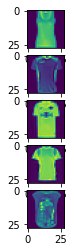

In [161]:
def plot_images(x, size=28, i=0):
    plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(5,1) 
    
    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0].imshow(x[i+0].reshape(size,size)*255)
    axarr[1].imshow(x[i+1].reshape(size,size)*255)
    axarr[2].imshow(x[i+2].reshape(size,size)*255)
    axarr[3].imshow(x[i+3].reshape(size,size)*255)
    axarr[4].imshow(x[i+4].reshape(size,size)*255)
    
plot_images(x_train, size=28, i=1500)

In [170]:
train_reduce[0].shape

(36,)

In [169]:
train_reduce[1]

array([0.09882118, 0.13621559, 0.        , 0.07654655, 0.12884705,
       0.0625    , 0.03125   , 0.06987712, 0.06987712, 0.        ,
       0.03125   , 0.0625    , 0.        , 0.10364452, 0.        ,
       0.05412659, 0.1711633 , 0.72348981, 0.08838835, 0.23799291,
       0.14657549, 0.125     , 0.11692679, 0.0625    , 0.03125   ,
       0.20963137, 0.04419417, 0.03125   , 0.03125   , 0.08267973,
       0.03125   , 0.06987712, 0.05412659, 0.        , 0.06987712,
       0.03125   ])

<Figure size 432x288 with 0 Axes>

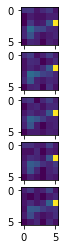

In [167]:
plot_images(train_reduce, size=6, i=25)

In [141]:
#Function to decode the training set values compressed
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with decode values
'''
def decoder_result_train(params):
    reduce = [] #List to save the decoded values
    #For each row in the test set reduced we will
    for i in range(len(train_reduce)):
        #Create a initial circuit with 6 qubits and a list of 48 zeros and the i row of the test reduced values
        circuit_init = input_data(n,np.concatenate((np.zeros(48), train_reduce[i]), axis=0))
        #Create the inverse VQC 
        circuit_vqc = vqc(n,num_layers,params).inverse()

        #Create a new circuit to combine the inicial circuit and the VQC
        circuit_full = QuantumCircuit(n,n)
        
        #Combine the initial circuit, the quantum variatinal circuit
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        #We will execute the full circuit in the qasm simulator
        job = execute( circuit_full, Aer.get_backend('statevector_simulator') )
        result = job.result().get_statevector() #Get the results of the execution
        reduce.append(result) #Save the results
    return reduce
     
#Call the decoder_result_train function    
decoder_train =decoder_result_train(params)

36

In [124]:
circuit_init.draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
c: 1/»
     »
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [4]:
#your submission

# Functions 'encode' and 'decode' are dummy.
def encode(image):
    q = qiskit.QuantumRegister(3)
    circuit = qiskit.QuantumCircuit(q)
    if image[0][0]==0:
        circuit.rx(np.pi,0)
    return circuit


def run_part2(image):

    #loade the quantum classifier circuit
    classifier=qiskit.QuantumCircuit.from_qasm_file('part2.qasm')
    
    #encode image into circuit
    circuit=encode(image)
    
    #append with classifier circuit
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))
    
    #simulate circuit
    histogram=simulate(qc)
        
    #convert histogram to category
    label=histogram_to_category(histogram)
        
    return circuit,label
#score

In [10]:
#how we grade your submission

score=0
gatecount=0
n=len(dataset)

for data in dataset:
    #run part 2
    circuit,label=run_part2(data['image'])
    
    #count the gate used in the circuit for score calculation
    gatecount+=count_gates(circuit)[2]
    
    #check label
    if label==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

1.0
